# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [6]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define layers for MNIST classification
        self.fc1 = nn.Linear(28 * 28, 128) #   # First fully connected layer (input to hidden layer)
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer (hidden layer to another hidden layer)
        self.fc3 = nn.Linear(64, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        # Flatten the input image from 28x28 to a vector of size 784
        # Here we define what we do with layers
        # We can add dropouts for overfittings. 
        # Dropout randomly sets a fraction of input units to 0 at each update during training time,
        # which helps prevent overfitting.
        # x = F.dropout(x, training=self.training)  # Apply dropout during training [It will randomly set some values to 0]
        
        # Flatten the input image from 28x28 to a vector of size 784 (which is the input to the first fully connected layer)
        # Here we transform the input data from a 2D tensor (image) to a 1D tensor (vector)
        # This is because the fully connected layer expects a 1D input.
        # The view function reshapes the tensor to have a new shape. 28*28 is the total number of pixels in an image. 784 is the number of neurons in the first fully connected layer. 1 is the batch size, which is not needed for this case.
        x = x.view(-1, 28 * 28)
        
        # Apply ReLU activation after each layer
        x = F.relu(self.fc1(x))  # First hidden layer # Relu is a function 
        x = F.relu(self.fc2(x))  # Second hidden layer
        
        # Output layer with log-softmax for classification [It will give me prob for classes for all the 10 classes]
        # Then we get the argmax which will give me the max probability of the 10 classes
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Return log probabilities [Here I got the max prob]


def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [8]:

@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [9]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304324

Test set: Average loss: 2.1982, Accuracy: 2845/10000 (28%)



# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

Training with hidden layer size: 32
Training with hidden layer size: 64
Training with hidden layer size: 128
Training with hidden layer size: 256
Training with hidden layer size: 512


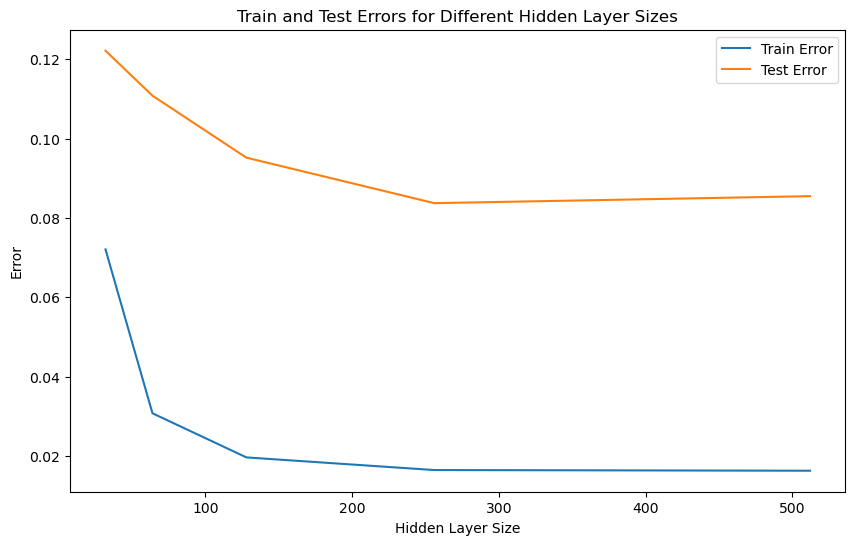

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Modify the Net class to have a single hidden layer
class SingleLayerNet(nn.Module):
    def __init__(self, hidden_size):
        super(SingleLayerNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)  # Single hidden layer
        self.fc2 = nn.Linear(hidden_size, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input images
        x = F.relu(self.fc1(x))  # ReLU activation for the hidden layer
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)  # Log softmax for classification


# Step 2: Modify the training function to store errors in numpy arrays
def train_and_record_errors(training_params, device, train_loader, test_loader, hidden_size):
    model = SingleLayerNet(hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_errors = []
    test_errors = []

    for epoch in range(training_params.epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_errors.append(train_loss / len(train_loader))  # Average train loss

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()

        test_loss /= len(test_loader.dataset)  # Average test loss
        test_errors.append(test_loss)

    return min(train_errors), min(test_errors)  # Return minimum train and test errors


# Step 3: Explore different hidden layer sizes
def explore_width(training_params, device, train_loader, test_loader):
    hidden_sizes = [32, 64, 128, 256, 512]  # Different sizes of hidden layers
    train_errors = []
    test_errors = []

    for hidden_size in hidden_sizes:
        print(f"Training with hidden layer size: {hidden_size}")
        train_error, test_error = train_and_record_errors(
            training_params, device, train_loader, test_loader, hidden_size
        )
        train_errors.append(train_error)
        test_errors.append(test_error)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_sizes, train_errors, label="Train Error")
    plt.plot(hidden_sizes, test_errors, label="Test Error")
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Error")
    plt.title("Train and Test Errors for Different Hidden Layer Sizes")
    plt.legend()
    plt.show()


# Example usage:
# Set the epochs to a larger number for real training, here it's 1 for quick results.
training_params = TrainingParameters(epochs=10, dry_run=False)

# Execute the pipeline for different hidden layer sizes
device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

# Call the function to explore the effect of width
explore_width(training_params, device, train_loader, test_loader)

Training with hidden layer size: 32

Test set: Average loss: 0.2250, Accuracy: 9325/10000 (93%)


Test set: Average loss: 0.1717, Accuracy: 9483/10000 (95%)


Test set: Average loss: 0.1484, Accuracy: 9547/10000 (95%)


Test set: Average loss: 0.1376, Accuracy: 9586/10000 (96%)


Test set: Average loss: 0.1319, Accuracy: 9596/10000 (96%)


Test set: Average loss: 0.1291, Accuracy: 9597/10000 (96%)


Test set: Average loss: 0.1287, Accuracy: 9594/10000 (96%)


Test set: Average loss: 0.1242, Accuracy: 9616/10000 (96%)


Test set: Average loss: 0.1266, Accuracy: 9614/10000 (96%)


Test set: Average loss: 0.1222, Accuracy: 9633/10000 (96%)

Training with hidden layer size: 64

Test set: Average loss: 0.1819, Accuracy: 9447/10000 (94%)


Test set: Average loss: 0.1298, Accuracy: 9602/10000 (96%)


Test set: Average loss: 0.1116, Accuracy: 9651/10000 (97%)


Test set: Average loss: 0.1077, Accuracy: 9668/10000 (97%)


Test set: Average loss: 0.1040, Accuracy: 9689/10000 (97%)


Test set: Av

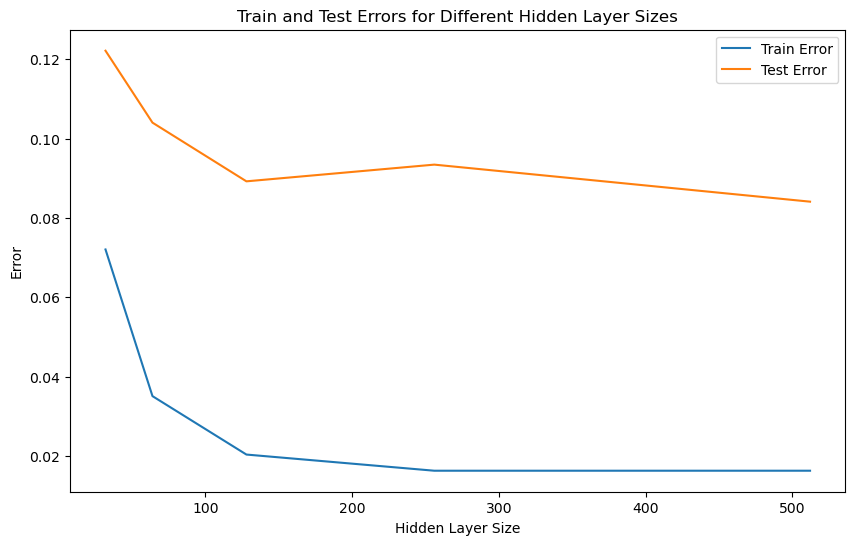

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Modify the Net class to have a single hidden layer
class SingleLayerNet(nn.Module):
    def __init__(self, hidden_size):
        super(SingleLayerNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)  # Single hidden layer
        self.fc2 = nn.Linear(hidden_size, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input images
        x = F.relu(self.fc1(x))  # ReLU activation for the hidden layer
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)  # Log softmax for classification


# Step 2: Modify the training function to store errors in numpy arrays and use the predict function
def train_and_record_errors(training_params, device, train_loader, test_loader, hidden_size):
    model = SingleLayerNet(hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_errors = []
    test_errors = []

    for epoch in range(training_params.epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_errors.append(train_loss / len(train_loader))  # Average train loss

        # Testing phase using the predict function
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # Average test loss
        test_errors.append(test_loss)

        # Use the predict function to log accuracy
        predict(model, device, test_loader)

    return min(train_errors), min(test_errors)  # Return minimum train and test errors


# Step 3: Explore different hidden layer sizes
def explore_width(training_params, device, train_loader, test_loader):
    hidden_sizes = [32, 64, 128, 256, 512]  # Different sizes of hidden layers
    train_errors = []
    test_errors = []

    for hidden_size in hidden_sizes:
        print(f"Training with hidden layer size: {hidden_size}")
        train_error, test_error = train_and_record_errors(
            training_params, device, train_loader, test_loader, hidden_size
        )
        train_errors.append(train_error)
        test_errors.append(test_error)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_sizes, train_errors, label="Train Error")
    plt.plot(hidden_sizes, test_errors, label="Test Error")
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Error")
    plt.title("Train and Test Errors for Different Hidden Layer Sizes")
    plt.legend()
    plt.show()


# Example usage:
training_params = TrainingParameters(epochs=10, dry_run=False)

# Execute the pipeline for different hidden layer sizes
device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

# Call the function to explore the effect of width
explore_width(training_params, device, train_loader, test_loader)

Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

In [6]:
# Your code here

Training with 1 hidden layers

Test set: Average loss: 0.3730, Accuracy: 8898/10000 (89%)


Test set: Average loss: 0.3590, Accuracy: 8940/10000 (89%)


Test set: Average loss: 0.3507, Accuracy: 8981/10000 (90%)


Test set: Average loss: 0.3449, Accuracy: 9009/10000 (90%)


Test set: Average loss: 0.3402, Accuracy: 9029/10000 (90%)


Test set: Average loss: 0.3375, Accuracy: 9034/10000 (90%)


Test set: Average loss: 0.3351, Accuracy: 9036/10000 (90%)


Test set: Average loss: 0.3331, Accuracy: 9050/10000 (90%)


Test set: Average loss: 0.3320, Accuracy: 9055/10000 (91%)


Test set: Average loss: 0.3311, Accuracy: 9066/10000 (91%)

Training with 2 hidden layers

Test set: Average loss: 0.4018, Accuracy: 8813/10000 (88%)


Test set: Average loss: 0.3993, Accuracy: 8837/10000 (88%)


Test set: Average loss: 0.3974, Accuracy: 8840/10000 (88%)


Test set: Average loss: 0.3899, Accuracy: 8861/10000 (89%)


Test set: Average loss: 0.3796, Accuracy: 8896/10000 (89%)


Test set: Average loss: 

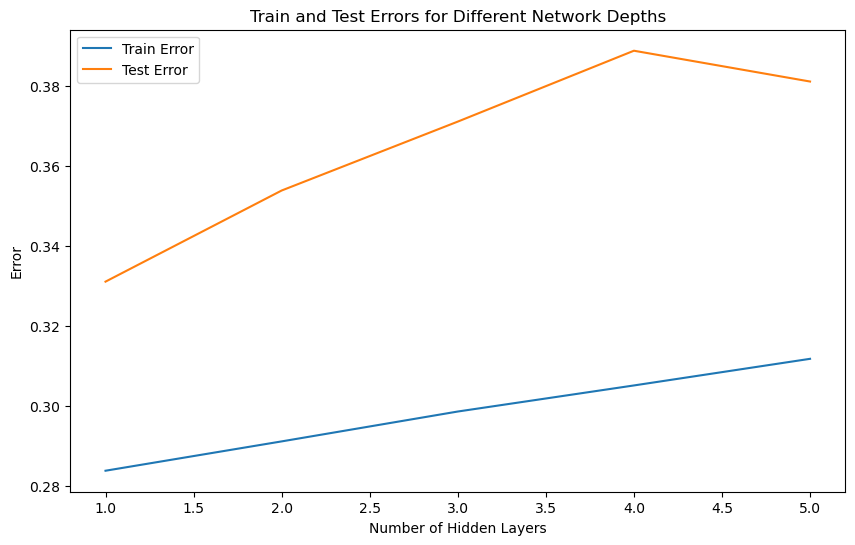

In [16]:
# Step 1: Modify the Net class to handle multiple hidden layers
class MultiLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))  # First layer

        # Add intermediate hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
        
        layers.append(nn.Linear(hidden_size, output_size))  # Output layer
        self.model = nn.Sequential(*layers)  # Create a sequential model with the layers

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input images
        x = self.model(x)  # Apply the stacked layers
        return F.log_softmax(x, dim=1)  # Log softmax for classification


# Step 2: Modify the training function to handle different depths
def train_and_record_errors_depth(training_params, device, train_loader, test_loader, num_layers):
    model = MultiLayerNet(28 * 28, 128, 10, num_layers).to(device)  # Fixed hidden size of 128 for simplicity
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_errors = []
    test_errors = []

    for epoch in range(training_params.epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_errors.append(train_loss / len(train_loader))  # Average train loss

        # Testing phase using the predict function
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # Average test loss
        test_errors.append(test_loss)

        # Use the predict function to log accuracy
        predict(model, device, test_loader)

    return min(train_errors), min(test_errors)  # Return minimum train and test errors


# Step 3: Explore different depths (number of hidden layers)
def explore_depth(training_params, device, train_loader, test_loader):
    num_layers_list = [1, 2, 3, 4, 5]  # Different depths (number of hidden layers)
    train_errors = []
    test_errors = []

    for num_layers in num_layers_list:
        print(f"Training with {num_layers} hidden layers")
        train_error, test_error = train_and_record_errors_depth(
            training_params, device, train_loader, test_loader, num_layers
        )
        train_errors.append(train_error)
        test_errors.append(test_error)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(num_layers_list, train_errors, label="Train Error")
    plt.plot(num_layers_list, test_errors, label="Test Error")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Error")
    plt.title("Train and Test Errors for Different Network Depths")
    plt.legend()
    plt.show()


# Example usage:
training_params = TrainingParameters(epochs=10, dry_run=False)

# Execute the pipeline for different network depths
device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

# Call the function to explore the effect of depth
explore_depth(training_params, device, train_loader, test_loader)
